# Physics 3A: Constitutive Law P11

In [1]:
from constitutive_laws_generator import LinearElasticConstitutiveLaw, NeoHookeanConstitutiveLaw
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
from sympy import *
from kan import *
from kan.compiler import kanpiler

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)
torch.set_default_dtype(torch.float64)

N = 1000
sigma = 0.2

F = torch.eye(3,3)[None,:,:].expand(N,3,3) + (torch.rand(N,3,3)*2-1)*sigma
det = torch.det(F)
F *= (det > 0)[:,None,None]

linear = LinearElasticConstitutiveLaw(young_modulus=1.0, poisson_ratio=0.2)
P_l = linear(F)
P11_l = P_l[:,[0],[0]]
P12_l = P_l[:,[0],[1]]

neo = NeoHookeanConstitutiveLaw(young_modulus=1.0, poisson_ratio=0.2)
P_n = neo(F)
P11_n = P_n[:,[0],[0]]
P12_n = P_n[:,[0],[1]]

# P11
# linear: P11 = 2 * mu * (F11 - 1) + lambda * (F11 + F22 + F33 - 3)
# neohookean: P11 = mu * (F11^2 + F21^2 + F31^2 - 1) + lambda * log(|F|)

# P12
# linear: P12 = mu * (F12 + F21)
# neohookean: P12 = mu * (F12 * F11 + F22 * F21 + F32 * F31)



saving model version 0.1


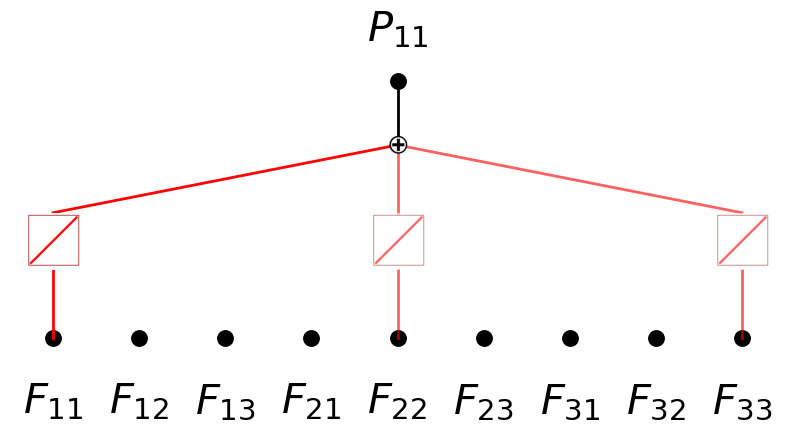

In [2]:
mu, lambda_ = linear.get_lame_parameters()
input_vars = F11, F12, F13, F21, F22, F23, F31, F32, F33 = symbols('F11 F12 F13 F21 F22 F23 F31 F32 F33')
P11_l_expr = 2 * mu * (F11 - 1) + lambda_ * (F11 + F22 + F33 - 3)
model = kanpiler(input_vars, P11_l_expr)

F_flatten = F.reshape(N, -1)

model.get_act(F_flatten)
model.plot(in_vars=input_vars, out_vars=[r'$P_{11}$'], varscale=0.75, scale=1.0, out_vars_offset=0.08)

saving model version 0.2


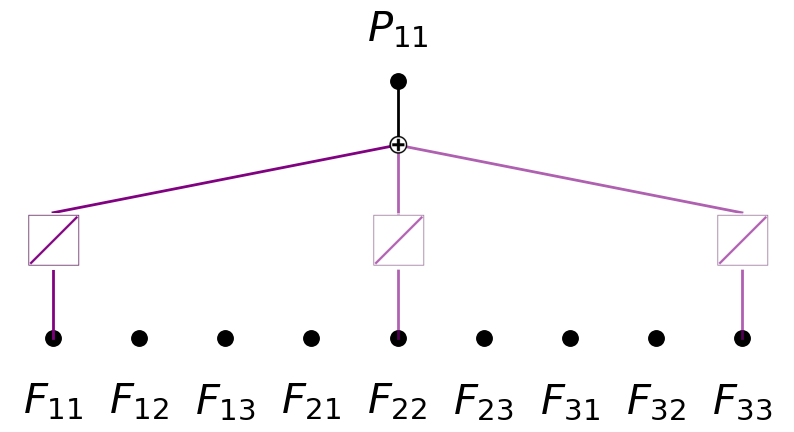

In [3]:
model.perturb()
model.get_act(F_flatten)
model.plot(in_vars=input_vars, out_vars=[r'$P_{11}$'], varscale=0.75, scale=1.0, out_vars_offset=0.08)

In [4]:
from kan.utils import create_dataset_from_data

dataset = create_dataset_from_data(F_flatten, P11_n)
model.fit(dataset, steps=20);

| train_loss: 6.38e-03 | test_loss: 6.99e-03 | reg: 1.36e+00 | : 100%|█| 20/20 [00:06<00:00,  3.00it

saving model version 0.3


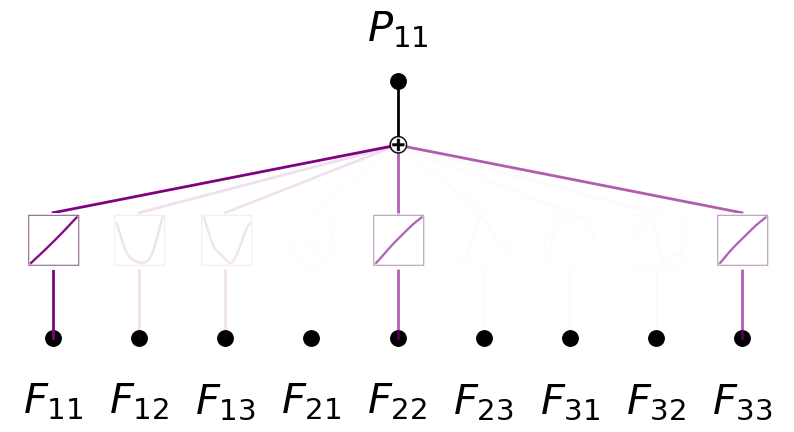

In [5]:
model.plot(in_vars=input_vars, out_vars=[r'$P_{11}$'], varscale=0.75, scale=1.0, out_vars_offset=0.08)

In [6]:
detF = F11 * F22 * F33 + F12 * F23 * F31 + F13 * F21 * F32 - F11 * F23 * F32 - F12 * F21 * F33 - F13 * F22 * F31
D = symbols('|F|')

dataset = augment_input(input_vars, [detF], dataset)

In [7]:
model.expand_width(0,1,perturb=True)

saving model version 0.4


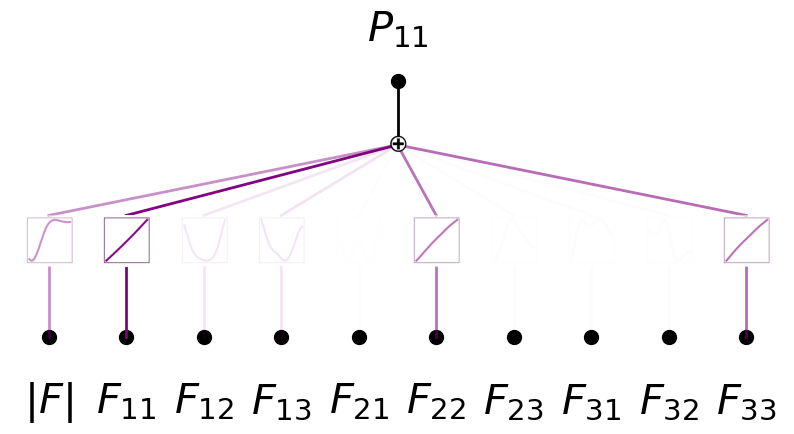

In [8]:
model.get_act(dataset)
model.plot(in_vars=[D] + list(input_vars), out_vars=[r'$P_{11}$'], varscale=0.75, scale=1.0, out_vars_offset=0.08)

In [9]:
model.fit(dataset, opt='LBFGS', steps=20);

| train_loss: 2.91e-04 | test_loss: 3.21e-04 | reg: 2.95e+00 | : 100%|█| 20/20 [00:17<00:00,  1.15it

saving model version 0.5


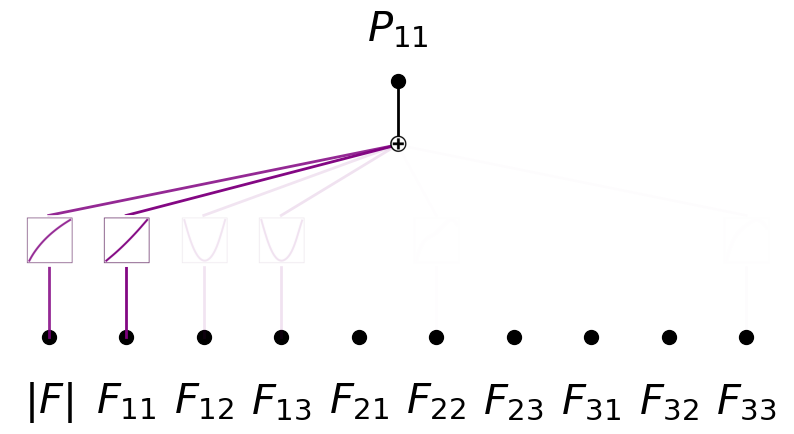

In [10]:
model.get_act(dataset)
model.plot(in_vars=[D] + list(input_vars), out_vars=[r'$P_{11}$'], varscale=0.75, scale=1.0, out_vars_offset=0.08)

saving model version 0.6


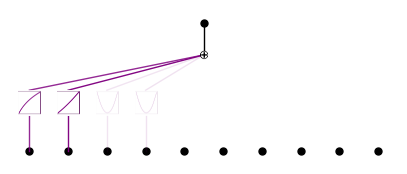

In [11]:
model = model.prune()
model.get_act(dataset)
model.plot()

In [12]:
model.auto_symbolic()

fixing (0,0,0) with log, r2=0.9999966767727161, c=2
fixing (0,1,0) with x^2, r2=0.9999980195191509, c=2
fixing (0,2,0) with x^2, r2=0.9998412733282299, c=2
fixing (0,3,0) with x^2, r2=0.9996084382228987, c=2
fixing (0,4,0) with 0
fixing (0,5,0) with 0
fixing (0,6,0) with 0
fixing (0,7,0) with 0
fixing (0,8,0) with 0
fixing (0,9,0) with 0
saving model version 0.7


In [13]:
model.fit(dataset, opt='LBFGS', steps=100);

| train_loss: 3.31e-11 | test_loss: 2.89e-11 | reg: 0.00e+00 | : 100%|█| 100/100 [00:18<00:00,  5.44

saving model version 0.8


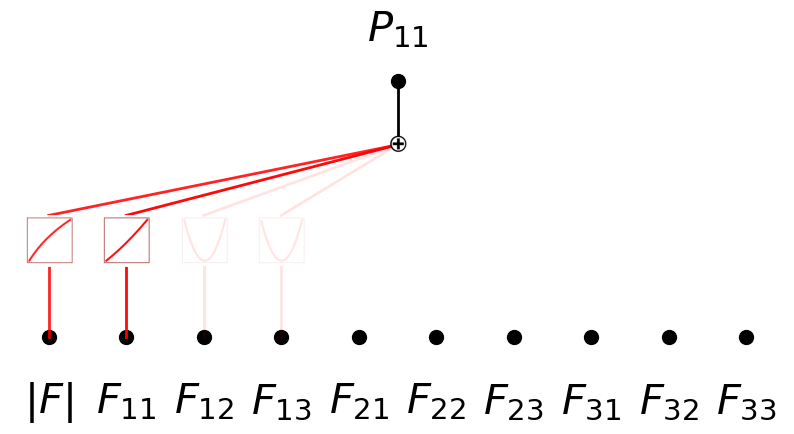

In [14]:
model.plot(in_vars=[D] + list(input_vars),out_vars=[r'$P_{11}$'], varscale=0.75, scale=1.0, out_vars_offset=0.08)

In [15]:
from kan.utils import ex_round

ex_round(ex_round(model.symbolic_formula(var= [D] + list(input_vars))[0][0],5),2)

0.42*F11**2 + 0.42*F12**2 + 0.42*F13**2 + 0.28*log(2.5*|F|) - 0.67

In [18]:
0.28*np.log(2.5) - 0.67

-0.41343859507523656